# Golf Predictor 

## (0) Load Data

In [1]:
import pandas as pd
import numpy
# dfRaw is raw dataset read from csv
dfRaw = pd.read_csv("../data/combined.csv")
distance_dict = {"A" : 1, "B" : 2, "C" : 3, "D" : 4, "E" : 5, "F" : 6}

In [2]:
def convert_rank_to_class(raw_ans):
    ans = ""
    if raw_ans < 21:
        ans = "A"
    elif raw_ans < 41:
        ans = "B"
    elif raw_ans < 61:
        ans = "C"
    elif raw_ans < 101:
        ans = "D"
    elif raw_ans < 201:
        ans = "E"
    else:
        ans = "F"
    return ans

In [3]:
dfConv = dfRaw

# drop label 
dfConv = dfConv.drop(["owgr_rank_year_plus_two"], axis=1)
dfConv["owgr_rank_year_plus_two"] = dfRaw["owgr_rank_year_plus_two"]

# remove all ranks greater than 300
for index, row in dfConv.iterrows():
    
    if row["top_tens"] != row["top_tens"]: # https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values?rq=1
        dfConv.loc[index, "top_tens"] = 0.0
    
    # remove all ranks greater than 300
    if row["owgr_rank_year_plus_two"] > 300:
        dfConv.drop(index, inplace=True) #https://stackoverflow.com/questions/28876243/how-to-delete-the-current-row-in-pandas-dataframe-during-df-iterrows
    

dfConv.head()


,Unnamed: 0,name,owgr_points_current_avg,driving_dist_avg,top_tens,gir_pct,sg_p_avg,driving_acc_pct,scrambling_pct,adj_scoring_avg,sg_ott_avg,sg_apr_avg,sg_arg_avg,rounds,year,owgr_rank_year_plus_two
0,0,Tiger Woods,13.22,293.2,8.0,67.59,0.426,62.50,60.00,68.944,-0.142,1.533,0.247,43,2013,299
1,1,Adam Scott,9.25,297.8,6.0,68.80,-0.027,61.84,56.38,69.300,0.734,0.548,0.055,44,2013,13
2,2,Phil Mickelson,8.52,287.9,7.0,66.67,0.661,57.30,58.55,69.742,0.021,0.494,0.260,57,2013,24
3,3,Henrik Stenson,8.23,290.9,8.0,71.96,0.004,70.09,57.28,69.248,0.710,0.776,0.128,44,2013,6
4,4,Justin Rose,7.78,296.6,7.0,68.89,-0.188,63.57,60.71,69.225,0.459,0.961,0.491,46,2013,7


### (0.1) K-Fold

In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits()
trainSets = []
testSets = []
for k in kf.split(dfConv):
    trainSets.append(dfConv.iloc[k[0]])
    testSets.append(dfConv.iloc[k[1]])

In [5]:
featureNames = dfConv.columns[2:-2] # Skip ID, name, year, and rank as label
nFeatures = featureNames.shape[0]
print("Number of features:", nFeatures)
featureNames

Number of features: 13


Index(['owgr_points_current_avg', 'driving_dist_avg', 'top_tens', 'gir_pct',
       'sg_p_avg', 'driving_acc_pct', 'scrambling_pct', 'adj_scoring_avg',
       'sg_ott_avg', 'sg_apr_avg', 'sg_arg_avg', 'rounds', 'year'],
      dtype='object')

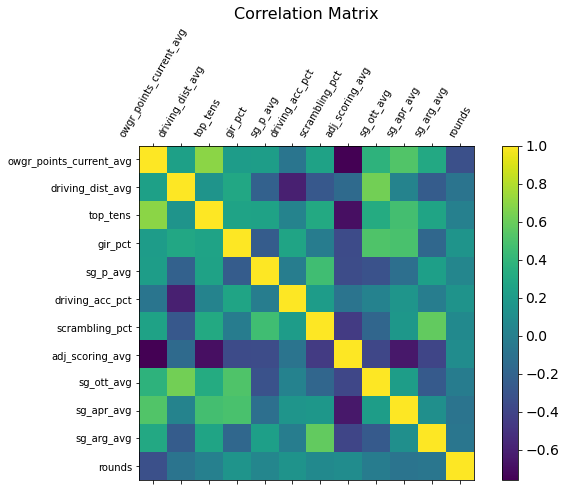

In [6]:
# feature correlation
import matplotlib.pyplot as plt

df = dfConv[featureNames]

f = plt.figure(figsize=(10, 6))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=60)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

plt.show()

### (0.2) Select Training Instances (features and values) from the Training Data

In [7]:
trainingInstancesList = []
for train in trainSets:
    trainingInstances_x = []
    trainingInstances_y = []
    for instance in train.to_numpy():
        featureValues = list(instance[2:-2])
        label = instance[-1]
        trainingInstances_x.append(featureValues)
        trainingInstances_y.append(label)
    nTrainingInstances = len(trainingInstances_x)
    trainingInstancesList.append((trainingInstances_x, trainingInstances_y, nTrainingInstances))
    print("Number of training instances:", nTrainingInstances)

Number of training instances: 1346
Number of training instances: 1346
Number of training instances: 1346
Number of training instances: 1347
Number of training instances: 1347


### (0.3) Select Test Instances from the Data

In [8]:
testInstancesList = []
for test in testSets:    
    testInstances_x = []
    testInstances_y = []
    for instance in test.to_numpy():
        featureValues = list(instance[2:-2])
        label = instance[-1]
        testInstances_x.append(featureValues)
        testInstances_y.append(label)
    nTrainingInstances = len(trainingInstances_x)
    print("Number of training instances:", nTrainingInstances)
    testInstancesList.append((testInstances_x, testInstances_y, nTrainingInstances))

Number of training instances: 1347
Number of training instances: 1347
Number of training instances: 1347
Number of training instances: 1347
Number of training instances: 1347


### (0.4) Convert Rank to Class (except for Neural Network)

In [9]:
import copy # https://docs.python.org/3/library/copy.html
trainingInstancesListRegression = copy.deepcopy(trainingInstancesList) # https://stackoverflow.com/questions/28684154/python-copy-a-list-of-lists
for i, trainingInstances in enumerate(trainingInstancesList):
    trainingInstancesListRegression.append(trainingInstances[:])
    for j, rank in enumerate(trainingInstances[1]):
        trainingInstancesList[i][1][j] = convert_rank_to_class(rank)

# convert test instances final rank to a class
for i, testInstances in enumerate(testInstancesList):
    for j, rank in enumerate(testInstances[1]):
        testInstancesList[i][1][j] = convert_rank_to_class(rank)
     

### (0.5) Label Distribution

In [10]:
label_dict = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F" : 0}

# convert test instances final rank to a class
for i, testInstances in enumerate(testInstancesList):
    for j, rank in enumerate(testInstances[1]):
        label_dict[testInstancesList[i][1][j]] = label_dict[testInstancesList[i][1][j]] + 1
print(label_dict)

{'A': 247, 'B': 200, 'C': 172, 'D': 268, 'E': 480, 'F': 316}


## 1. Neural Network with KNN

### Uses Both Neural Network Regression and KNN Classification (5 Neighbors)

In [11]:
from sklearn.neural_network import MLPRegressor # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn import metrics
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
for trainingInstances, testInstances in zip(trainingInstancesListRegression, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    
    trainingInstances_x_forNN = []
    # drop the following cols "rounds", "scrambling_pct", "year", "gir_pct", "sg_apr_avg","sg_arg_avg"
    for i, inst in enumerate(trainingInstances_x):
        trainingInstances_x_forNN.append([])
        for j, val in enumerate(inst):
            if j != 3 and j != 6 and j < 9:
                trainingInstances_x_forNN[i].append(val)
     
    testInstances_x_forNN = []
    # drop the following cols "rounds", "scrambling_pct", "year", "gir_pct", "sg_apr_avg","sg_arg_avg"
    for i, inst in enumerate(testInstances_x):
        testInstances_x_forNN.append([])
        for j, val in enumerate(inst):
            if j != 3 and j != 6 and j < 9:
                testInstances_x_forNN[i].append(val)
            
    
    # use min max scaling on input
    trainingInstancesScaled = scaler1.fit_transform(trainingInstances_x_forNN)
    testInstancesScaled = scaler2.fit_transform(testInstances_x_forNN)
    
    # save training output as class for KNN
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    trainingInstances_y_WithClass = []
    for val in trainingInstances_y:
        trainingInstances_y_WithClass.append(convert_rank_to_class(val))
         
    # train KNN
    clf_knn.fit(trainingInstances_x_forNN, trainingInstances_y_WithClass)
    
    # save testing output as class for KNN
    testInstances_y_WithClass = []
    for val in trainingInstances_y:
        testInstances_y_WithClass.append(convert_rank_to_class(val))

    # use KNN model to predict
    y_pred2 = clf_knn.predict(testInstances_x_forNN)
    
    # train neural network and predict
    clf_nn = MLPRegressor(max_iter=10000, random_state=0, hidden_layer_sizes=(7,))
    clf_nn.fit(trainingInstancesScaled, trainingInstances_y)
    y_pred_raw = clf_nn.predict(testInstancesScaled)
    
    # convert regression output to class output 
    y_pred = []
    for i, val in enumerate(y_pred_raw):
        nn_pred_val = convert_rank_to_class(val)
        if y_pred2[i] == 'F': # if KNN said F, go with KNN's prediction
            y_pred.append('F')
        else:
            y_pred.append(nn_pred_val)
    
    
    
    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None))
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    #print("Predicted:", y_pred)
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))
    
    
print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

Accuracy: 0.4124629080118694
F1 Micro: 0.4124629080118694
F1 Macro: 0.3326816861626153
Accuracy: 0.31750741839762614
F1 Micro: 0.31750741839762614
F1 Macro: 0.24355785177577913
Accuracy: 0.29376854599406527
F1 Micro: 0.29376854599406527
F1 Macro: 0.24648689646180444
Accuracy: 0.36904761904761907
F1 Micro: 0.36904761904761907
F1 Macro: 0.327731029004133
Accuracy: 0.3630952380952381
F1 Micro: 0.3630952380952381
F1 Macro: 0.36262730988553665
Overall Precision:  [0.63981318 0.2907558  0.20041983 0.20932839 0.38013688 0.3510265 ]
Overall Recall:  [0.45596725 0.21667219 0.11756272 0.20943471 0.52563729 0.31878402]
Overall Accuracy:  0.3511763459092836
Overall F1 Micro:  0.3511763459092836
Overall F1 Macro:  0.30261695465797367
Accuracy Stdev:  0.04649391696708961
F1 Micro Stdev:  0.04649391696708961
F1 Macro Stdev:  0.05425497353147425


## 2. SVM

### 2.1 Kernel SVM -- Quadratic Kernel

In [12]:
from sklearn.svm import SVC
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
for trainingInstances, testInstances in zip(trainingInstancesList, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    
    trainingInstancesScaled = scaler1.fit_transform(trainingInstances_x)
    testInstancesScaled = scaler2.fit_transform(testInstances_x)
    
    clf = SVC(kernel='poly', degree=2)
    clf.fit(trainingInstancesScaled, trainingInstances_y)
    y_pred = clf.predict(testInstancesScaled)
    
    
    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None, zero_division=True))
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    #print("Predicted:", y_pred)
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))
    y_pred_svm = y_pred
    
print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

Accuracy: 0.4094955489614243
F1 Micro: 0.4094955489614243
F1 Macro: 0.2632559466856599
Accuracy: 0.32047477744807124
F1 Micro: 0.32047477744807124
F1 Macro: 0.1875882569046079
Accuracy: 0.3293768545994065
F1 Micro: 0.3293768545994065
F1 Macro: 0.2363624849876966
Accuracy: 0.34523809523809523
F1 Micro: 0.34523809523809523
F1 Macro: 0.29641932141932137
Accuracy: 0.31547619047619047
F1 Micro: 0.31547619047619047
F1 Macro: 0.20362429851109423
Overall Precision:  [0.46518579 0.24475783 0.44285714 0.1530303  0.36192712 0.40180375]
Overall Recall:  [0.55318476 0.30484174 0.02       0.04327643 0.66818668 0.14668175]
Overall Accuracy:  0.34401229334463757
Overall F1 Micro:  0.34401229334463757
Overall F1 Macro:  0.237450061701676
Accuracy Stdev:  0.038314746655891366
F1 Micro Stdev:  0.038314746655891366
F1 Macro Stdev:  0.0440876455132522


## 3. KNN

### 3.1 KNN (with 5 neighbors)

In [13]:
# KNN WITH n_neighbors=5
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
for trainingInstances, testInstances in zip(trainingInstancesList, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    trainingInstancesScaled = scaler1.fit_transform(trainingInstances_x)
    testInstancesScaled = scaler2.fit_transform(testInstances_x)
    
    clf = KNeighborsClassifier() # n_neighbors=5
    clf.fit(trainingInstances_x, trainingInstances_y)
    y_pred = clf.predict(testInstances_x)

    
    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None))
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))

print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

Accuracy: 0.29376854599406527
F1 Micro: 0.29376854599406527
F1 Macro: 0.23218674672180958
Accuracy: 0.27299703264094954
F1 Micro: 0.27299703264094954
F1 Macro: 0.23231607365473636
Accuracy: 0.28486646884273
F1 Micro: 0.28486646884273
F1 Macro: 0.25493801344420725
Accuracy: 0.27976190476190477
F1 Micro: 0.27976190476190477
F1 Macro: 0.22758595671639148
Accuracy: 0.2857142857142857
F1 Micro: 0.2857142857142857
F1 Macro: 0.2562070031003582
Overall Precision:  [0.38454445 0.17476101 0.0774359  0.17815657 0.35116887 0.26940716]
Overall Recall:  [0.48426001 0.16098638 0.05464926 0.18418819 0.42102649 0.19784876]
Overall Accuracy:  0.28342164759078703
Overall F1 Micro:  0.28342164759078703
Overall F1 Macro:  0.24064675872750058
Accuracy Stdev:  0.007688763213434875
F1 Micro Stdev:  0.007688763213434875
F1 Macro Stdev:  0.013765153762419819


### 3.2 KNN (with 3 neighbors)

In [14]:
# KNN WITH n_neighbors=3
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
for trainingInstances, testInstances in zip(trainingInstancesList, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    trainingInstancesScaled = scaler1.fit_transform(trainingInstances_x)
    testInstancesScaled = scaler2.fit_transform(testInstances_x)
    
    clf = KNeighborsClassifier(n_neighbors=3) # n_neighbors = 3
    clf.fit(trainingInstances_x, trainingInstances_y)
    y_pred = clf.predict(testInstances_x)

    
    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None))
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))

print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

Accuracy: 0.26112759643916916
F1 Micro: 0.26112759643916916
F1 Macro: 0.23112623308875543
Accuracy: 0.22255192878338279
F1 Micro: 0.22255192878338276
F1 Macro: 0.20359842982944684
Accuracy: 0.2344213649851632
F1 Micro: 0.2344213649851632
F1 Macro: 0.21010058122876377
Accuracy: 0.26785714285714285
F1 Micro: 0.26785714285714285
F1 Macro: 0.23080318601055314
Accuracy: 0.25892857142857145
F1 Micro: 0.25892857142857145
F1 Macro: 0.2418149164806831
Overall Precision:  [0.3349094  0.14213983 0.08022887 0.20400299 0.35101328 0.23722462]
Overall Recall:  [0.54721486 0.20422648 0.08292627 0.1887061  0.26838865 0.15498073]
Overall Accuracy:  0.2489773208986859
Overall F1 Micro:  0.24897732089868585
Overall F1 Macro:  0.22348866932764047
Accuracy Stdev:  0.01945045925553679
F1 Micro Stdev:  0.0194504592555368
F1 Macro Stdev:  0.015988655348894206


## 4. Gaussian Naive Bayes

Accuracy: 0.42729970326409494
F1 Micro: 0.42729970326409494
F1 Macro: 0.3435544973916536
Accuracy: 0.3768545994065282
F1 Micro: 0.3768545994065282
F1 Macro: 0.32508003133773933
Accuracy: 0.32047477744807124
F1 Micro: 0.32047477744807124
F1 Macro: 0.2840024550150769
Accuracy: 0.33630952380952384
F1 Micro: 0.33630952380952384
F1 Macro: 0.2830493342916723
Accuracy: 0.3898809523809524
F1 Micro: 0.3898809523809524
F1 Macro: 0.3241196983844043
Overall Precision:  [0.59978644 0.27242424 0.025      0.22292625 0.37360374 0.36278414]
Overall Recall:  [0.56600864 0.29286652 0.00645161 0.1565332  0.51589513 0.41310308]
Overall Accuracy:  0.3701639112618341
Overall F1 Micro:  0.3701639112618341
Overall F1 Macro:  0.3119612032841093
Accuracy Stdev:  0.04275849422922111
F1 Micro Stdev:  0.04275849422922111
F1 Macro Stdev:  0.02709085020157804


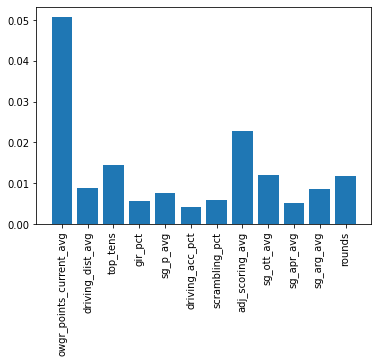

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
importances = [0] * nFeatures
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
for trainingInstances, testInstances in zip(trainingInstancesList, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    trainingInstancesScaled = scaler1.fit_transform(trainingInstances_x)
    testInstancesScaled = scaler2.fit_transform(testInstances_x)
    
    clf = GaussianNB()
    clf.fit(trainingInstances_x, trainingInstances_y)
    y_pred = clf.predict(testInstances_x)
    
    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None))
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))
    
    imps = permutation_importance(clf, testInstances_x, testInstances_y)
    importances = numpy.add(importances, imps.importances_mean)


print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

import matplotlib.pyplot as plt
plt.bar(featureNames, numpy.divide(importances, len(testSets)))
plt.xticks(rotation='vertical')
plt.show()

# 5. Naive Solution - Random Guess

In [16]:
import random
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]
acc_stdev = []
f1micro_stdev = []
f1macro_stdev = []
representative_sample = ["A", "A", "B", "B", "C", "C", "D", "D", "D", "D", "E", "E", "E", "E", "E", "E", "E", "E", "E",
                        "E", "F","F", "F", "F", "F", "F", "F", "F", "F", "F"]

for trainingInstances, testInstances in zip(trainingInstancesList, testInstancesList):
    trainingInstances_x = trainingInstances[0]
    trainingInstances_y = trainingInstances[1]
    testInstances_x = testInstances[0]
    testInstances_y = testInstances[1]
    y_pred = [random.sample(representative_sample, 1)[0] for y in testInstances_y]
    
    

    # Calculations for Precision and Recall
    prec = numpy.add(prec, metrics.precision_score(testInstances_y, y_pred, average=None)) # https://www.educative.io/edpresso/how-to-add-one-array-to-another-array-in-python
    recall = numpy.add(recall, metrics.recall_score(testInstances_y, y_pred, average=None))
    
    print("Accuracy:", metrics.accuracy_score(testInstances_y, y_pred))
    acc_sum += metrics.accuracy_score(testInstances_y, y_pred)
    acc_stdev.append(metrics.accuracy_score(testInstances_y, y_pred))
    print("F1 Micro:", metrics.f1_score(testInstances_y, y_pred, average='micro'))
    f1micro_sum += metrics.f1_score(testInstances_y, y_pred, average='micro')
    f1micro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='micro'))
    print("F1 Macro:", metrics.f1_score(testInstances_y, y_pred, average='macro'))
    f1macro_sum += metrics.f1_score(testInstances_y, y_pred, average='macro')
    f1macro_stdev.append(metrics.f1_score(testInstances_y, y_pred, average='macro'))

print("Overall Precision: ", numpy.divide(prec, len(testSets)))
print("Overall Recall: ", numpy.divide(recall, len(testSets)))
print("Overall Accuracy: ", acc_sum / len(testSets))
print("Overall F1 Micro: ", f1micro_sum / len(testSets))
print("Overall F1 Macro: ", f1macro_sum / len(testSets))

print("Accuracy Stdev: ", numpy.std(acc_stdev, ddof=1))
print("F1 Micro Stdev: ", numpy.std(f1micro_stdev, ddof=1))
print("F1 Macro Stdev: ", numpy.std(f1macro_stdev, ddof=1))

Accuracy: 0.19881305637982197
F1 Micro: 0.19881305637982194
F1 Macro: 0.15333418942503052
Accuracy: 0.19584569732937684
F1 Micro: 0.19584569732937684
F1 Macro: 0.15150214612016086
Accuracy: 0.17210682492581603
F1 Micro: 0.17210682492581603
F1 Macro: 0.1537273883603273
Accuracy: 0.23511904761904762
F1 Micro: 0.23511904761904762
F1 Macro: 0.18493554179114233
Accuracy: 0.17857142857142858
F1 Micro: 0.17857142857142858
F1 Macro: 0.1482975332640579
Overall Precision:  [0.14559524 0.16090462 0.11377193 0.15983487 0.26322021 0.17976788]
Overall Recall:  [0.06109391 0.09031653 0.07191756 0.15039045 0.30756612 0.30005815]
Overall Accuracy:  0.1960912109650982
Overall F1 Micro:  0.1960912109650982
Overall F1 Macro:  0.1583593597921438
Accuracy Stdev:  0.02456030487441669
F1 Micro Stdev:  0.02456030487441669
F1 Macro Stdev:  0.015010518633878828


# 6. Naive Solution - Use Last Year's Rank

In [17]:
import random
acc_sum = 0
f1micro_sum = 0
f1macro_sum = 0
prec = [0,0,0,0,0,0]
recall = [0,0,0,0,0,0]

main_data = pd.read_csv("../data/combined.csv")
df_continuity = pd.read_csv("../owgr_2004-2019.csv")

y_pred = []
y_ans = []

# run predictions from 2004 to 2019 (using players in main_data)
for index, row in main_data.iterrows():
            
    if row["year"] < 2004 or row["year"] > 2019:
        continue
        
    player = (df_continuity['name'] == row['name']) & (df_continuity['year'] == row['year'])
    player_ranking_data = df_continuity.loc[player]

    current_rank = player_ranking_data['current_rank'].values[0]
    rank_year_plus_two = player_ranking_data['rank_year_plus_two'].values[0]

    if rank_year_plus_two > 300:
        continue

    guess_instance = convert_rank_to_class(current_rank)
    ans_instance = convert_rank_to_class(rank_year_plus_two)

    y_pred.append(guess_instance)
    y_ans.append(ans_instance)

print(len(y_pred))
print(len(y_ans))


# Calculations for Precision and Recall
prec = numpy.add(prec, metrics.precision_score(y_ans, y_pred, average=None)) # from https://stackoverflow.com/questions/45890328/sklearn-metrics-for-multiclass-classification
recall = numpy.add(recall, metrics.recall_score(y_ans, y_pred, average=None))

print("Accuracy:", metrics.accuracy_score(y_ans, y_pred))
acc_sum += metrics.accuracy_score(y_ans, y_pred)
print("F1 Micro:", metrics.f1_score(y_ans, y_pred, average='micro'))
f1micro_sum += metrics.f1_score(y_ans, y_pred, average='micro')
print("F1 Macro:", metrics.f1_score(y_ans, y_pred, average='macro'))
f1macro_sum += metrics.f1_score(y_ans, y_pred, average='macro')

print("Overall Precision: ", prec/ 1)
print("Overall Recall: ", recall/ 1)
print("Overall Accuracy: ", acc_sum / 1)
print("Overall F1 Micro: ", f1micro_sum / 1)
print("Overall F1 Macro: ", f1macro_sum / 1)

1683
1683
Accuracy: 0.3196672608437314
F1 Micro: 0.3196672608437314
F1 Macro: 0.307310147545276
Overall Precision:  [0.54612546 0.22943723 0.14754098 0.20437956 0.35159817 0.34965035]
Overall Recall:  [0.59919028 0.265      0.15697674 0.20895522 0.32083333 0.3164557 ]
Overall Accuracy:  0.3196672608437314
Overall F1 Micro:  0.3196672608437314
Overall F1 Macro:  0.307310147545276
